In [26]:
import numpy as np
import matplotlib
matplotlib.rcParams['image.cmap'] = 'jet'
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time as clock
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import trange
from time import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from diffusion_equation import compute_solution
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor

# Data from simulator

In [137]:
# # 2000
# sim_data = np.loadtxt("2000_data/sim_2k.txt", dtype=np.float32)
# x_list = np.loadtxt("2000_data/x_2k.txt", dtype=np.float32)
# y_list = np.loadtxt("2000_data/y_2k.txt", dtype=np.float32)
# t_list = np.loadtxt("2000_data/t_2k.txt", dtype=np.float32)
# sim_data, x_list, y_list, t_list

# 5000
n_points = 500
rand_points = np.random.randint(0, 5000, n_points)

# 5000
sim_data = np.loadtxt("data_5k_200225/sim_5000.txt", dtype=np.float32)[rand_points]
x_list = np.loadtxt("data_5k_200225/x_5000.txt", dtype=np.float32)[rand_points]
y_list = np.loadtxt("data_5k_200225/y_5000.txt", dtype=np.float32)[rand_points]
t_list = np.loadtxt("data_5k_200225/t_5000.txt", dtype=np.float32)[rand_points]
sim_data, x_list, y_list, t_list

(array([[ 7.1632266e-01,  1.1439904e-33,  1.0000000e+00],
        [ 3.1087476e-01,  2.1013725e-34,  1.0000000e+00],
        [ 8.3306171e-02, -8.1178170e-34,  1.0000000e+00],
        ...,
        [ 7.0152581e-01,  1.7250380e-34,  1.0000000e+00],
        [ 9.9393971e-02, -5.4223424e-34,  1.0000000e+00],
        [ 8.8455224e-01,  3.2135290e-01,  6.7864710e-01]], dtype=float32),
 array([20., 39., 51., 48., 23., 60.,  0., 41., 32., 43., 62.,  2., 33.,
        15., 14., 39., 10., 45., 30., 33., 61., 48., 35., 10.,  7., 45.,
        29., 52.,  7., 31., 51., 15., 47., 43., 60., 30., 56., 20., 37.,
        46., 30., 22., 33.,  1., 49., 58., 54., 26., 15., 14.,  4., 58.,
        33., 38., 37., 34., 29., 21., 40., 31., 39., 28., 41., 42., 17.,
        16., 22., 56., 62., 35., 43., 25., 39., 42., 20.,  5., 45., 17.,
        42.,  0.,  0., 49., 45., 31., 45., 27., 35., 49., 33., 48., 23.,
        50., 22., 21., 39.,  7., 53., 56.,  5.,  8., 53.,  3., 31., 60.,
        58.,  5., 48., 44., 32., 32., 

In [130]:
sim_data.shape

(5000, 3)

In [103]:
# # 5000
# sim_data = np.loadtxt("/Users/kirill/edu/3course/PINN_project/TwoPhase2/data_5k/sim_5000.txt", dtype=np.float32)
# x_list = np.loadtxt("/Users/kirill/edu/3course/PINN_project/TwoPhase2/data_5k/x_5000.txt", dtype=np.float32)
# y_list = np.loadtxt("/Users/kirill/edu/3course/PINN_project/TwoPhase2/data_5k/y_5000.txt", dtype=np.float32)
# t_list = np.loadtxt("/Users/kirill/edu/3course/PINN_project/TwoPhase2/data_5k/t_5000.txt", dtype=np.float32)
# sim_data, x_list, y_list, t_list
# 5000 3sigma
# sim_data = np.loadtxt("/Users/kirill/edu/3course/PINN_project/TwoPhase2/data_5k_3sigma/sim_5000.txt", dtype=np.float32)
# x_list = np.loadtxt("/Users/kirill/edu/3course/PINN_project/TwoPhase2/data_5k_3sigma/x_5000.txt", dtype=np.float32)
# y_list = np.loadtxt("/Users/kirill/edu/3course/PINN_project/TwoPhase2/data_5k_3sigma/y_5000.txt", dtype=np.float32)
# t_list = np.loadtxt("/Users/kirill/edu/3course/PINN_project/TwoPhase2/data_5k_3sigma/t_5000.txt", dtype=np.float32)
# sim_data, x_list, y_list, t_list

In [104]:
# # configuration of simulator
# # and parametrs of reservouir
# pwat = 2.0
# poil = 4.0
# vr = 0.3
# kwat = 1.0
# koil = 0.3


# pmin = 0.0
# pmax = 1.0
# nx0 = 50
# nx1 = 30
# nx2 = 1
# dx0 = 1.0 / nx0
# dx1 = 1.0 / nx1
# dx2 = 1.0 / nx2
# dt = 0
# niter = 100

# poro = 0.1 + np.zeros((nx0, nx1, nx2))
# perm = np.ones((nx0, nx1, nx2))

In [105]:
# configuration of simulator
# and parametrs of reservouir
perm = np.load('perm.npy')
nx0, nx1 = perm.shape
nx2 = 1
perm = np.reshape(perm, (nx0, nx1, nx2))
poro = 0.1 + np.zeros((nx0, nx1, nx2))

dx0 = 1.0 / nx0
dx1 = 1.0 / nx1
dx2 = 1.0 / nx2

pwat = 2.0
poil = 4.0
vr = 0.3
kwat = 1.0
koil = 0.3

pmin = 0.0
pmax = 1.0

niter = 5000
t_final = 3.0
dt = t_final / niter

In [140]:
dx0 = 1.0 / nx0
dx1 = 1.0 / nx1
dx2 = 1.0 / nx2

x = np.array(x_list * dx0)
y = np.array(y_list * dx1)
t = np.array(t_list * dt)

pwat1 = 2.0 * np.ones_like(x)
poil1 = 4.0 * np.ones_like(x)
kwat1 = 1.0 * np.ones_like(x)
koil1 = 0.3 * np.ones_like(x)

points = np.stack((t, x, y), -1)
points, sim_data

(array([[1.2214800e+02, 3.1250000e-01, 9.2187500e-01],
        [2.4882000e+01, 6.0937500e-01, 1.2500000e-01],
        [9.9840004e+01, 7.9687500e-01, 5.9375000e-01],
        ...,
        [8.1613998e+01, 3.5937500e-01, 8.1250000e-01],
        [1.1013600e+02, 7.9687500e-01, 7.1875000e-01],
        [1.2617800e+02, 1.0937500e-01, 3.5937500e-01]], dtype=float32),
 array([[ 7.1632266e-01,  1.1439904e-33,  1.0000000e+00],
        [ 3.1087476e-01,  2.1013725e-34,  1.0000000e+00],
        [ 8.3306171e-02, -8.1178170e-34,  1.0000000e+00],
        ...,
        [ 7.0152581e-01,  1.7250380e-34,  1.0000000e+00],
        [ 9.9393971e-02, -5.4223424e-34,  1.0000000e+00],
        [ 8.8455224e-01,  3.2135290e-01,  6.7864710e-01]], dtype=float32))

In [107]:
X_train, X_test, y_train, y_test = train_test_split(
    points, sim_data, test_size=0.33, random_state=42)

# Initialazing XGBoost model

In [108]:
xgb_regressor = xgb.XGBRegressor(tree_method='hist', verbosity=2)
multioutput_regressor = MultiOutputRegressor(xgb_regressor)
multioutput_regressor.fit(X_train, y_train)

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...))

In [109]:
mean_squared_error(multioutput_regressor.predict(X_train), y_train)

8.729371e-07

In [110]:
mean_squared_error(multioutput_regressor.predict(X_test), y_test)

0.00063928735

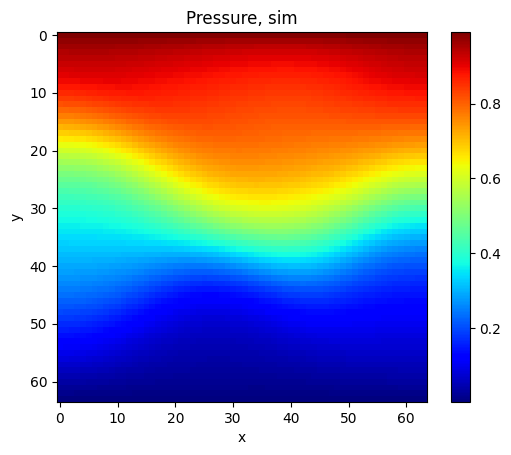

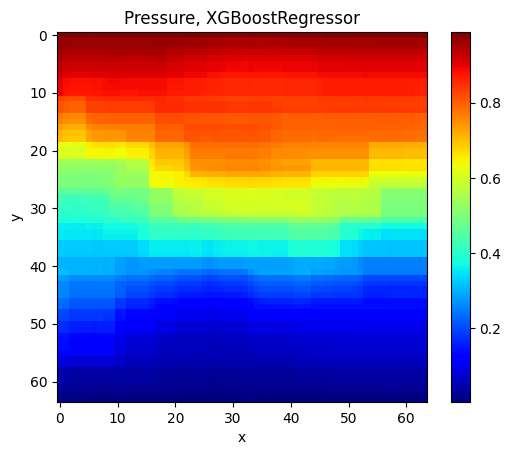

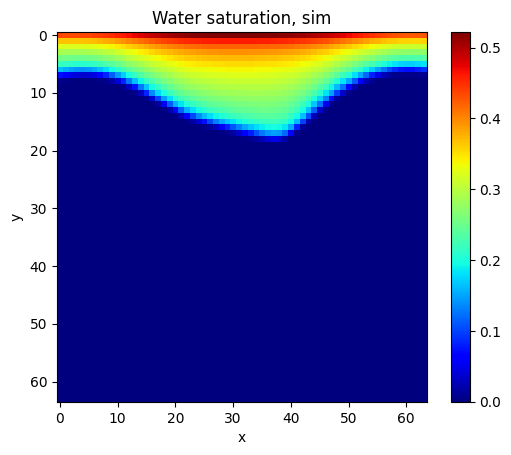

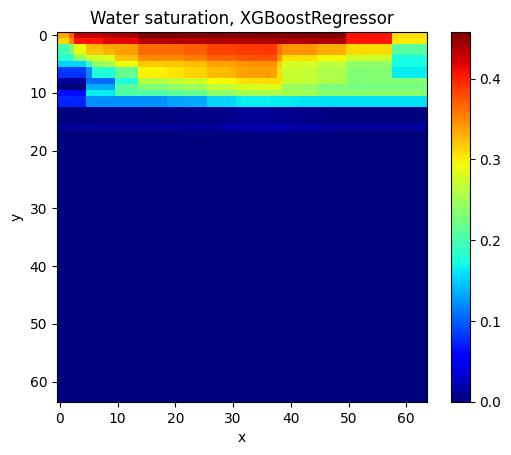

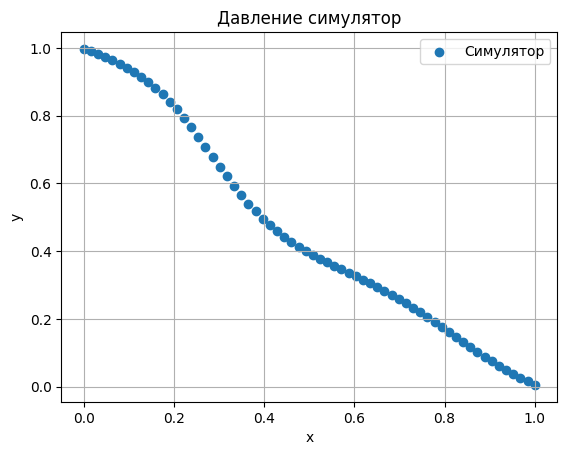

In [111]:
# pwat = 2.0
# poil = 4.0
# vr = 0.3
# kwat = 1.0
# koil = 0.3
# pmin = 0.0
# pmax = 1.0
# nx0 = 50
# nx1 = 30
# nx2 = 1
# dx0 = 1.0 / nx0
# dx1 = 1.0 / nx1
# dx2 = 1.0 / nx2
perm = np.load('perm.npy')
nx0, nx1 = perm.shape
nx2 = 1
perm = np.reshape(perm, (nx0, nx1, nx2))
poro = 0.1 + np.zeros((nx0, nx1, nx2))

dx0 = 1.0 / nx0
dx1 = 1.0 / nx1
dx2 = 1.0 / nx2

pwat = 2.0
poil = 4.0
vr = 0.3
kwat = 1.0
koil = 0.3

pmin = 0.0
pmax = 1.0
dt = 0.26e-1
niter = 100

# poro = 0.1 + np.zeros((nx0, nx1, nx2))
# perm = np.ones((nx0, nx1, nx2))

pres, swat, soil = compute_solution(perm, poro,
                                    dx0, dx1, dx2, dt * niter, niter,
                                    pwat, kwat, poil, koil, vr,
                                    pmin=0.0, pmax=1.0)

time_for_model = (niter * dt) * np.ones(64 * 64)
x_for_model = dx0 * torch.arange(64)
y_for_model = dx1 * torch.arange(64)
#     cartesian_points = np.transpose([np.tile(x_for_model, len(y_for_model)), 
#                                      np.repeat(y_for_model, len(x_for_model))])
cartesian_points = torch.cartesian_prod(x_for_model, y_for_model)
cartesian_points = cartesian_points.detach().numpy()
model_prediction = multioutput_regressor.predict(np.stack((time_for_model, cartesian_points[:, 0], cartesian_points[:, 1]), -1))


plt.figure()
plt.title('Pressure, sim')
plt.imshow(pres[:, :, :, -1])
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.savefig('color_pres_sim.png')
plt.show()

plt.figure()
plt.title('Pressure, XGBoostRegressor')
plt.imshow(model_prediction[:, 0].reshape(nx0, nx1, nx2))
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.savefig('color_tree_pres.png')
plt.show()



plt.figure()
plt.title('Water saturation, sim')
plt.imshow(swat[:, :, :, -1])
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

plt.figure()
plt.title('Water saturation, XGBoostRegressor')
plt.imshow(model_prediction[:, 1].reshape(nx0, nx1, nx2))
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.savefig('color_tree_swat.png')
plt.show()



plt.figure()
plt.title('Давление симулятор')
plt.scatter(np.linspace(0.0, 1.0, nx0), pres[:, 0, 0, 3], label='Симулятор')
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [11]:
def main2000(model):
    print('inside the main function')

    pwat = 2.0
    poil = 4.0
    vr = 0.3
    kwat = 1.0
    koil = 0.3

    # pwat = 1.0
    # poil = 1.0
    # vr = 1.0
    # kwat = 1.0
    # koil = 1.0
    pmin = 0.0
    pmax = 1.0
    nx0 = 50
    nx1 = 30
    nx2 = 1
    dx0 = 1.0 / nx0
    dx1 = 1.0 / nx1
    dx2 = 1.0 / nx2
    dt = 0.26e-1
    niter = 100

    poro = 0.1 + np.zeros((nx0, nx1, nx2))
    perm = np.ones((nx0, nx1, nx2))
    swat = np.zeros((nx0, nx1, nx2))
    soil = np.ones((nx0, nx1, nx2))


    pres, swat, soil = compute_solution(perm, poro,
                                        dx0, dx1, dx2, dt * niter, niter,
                                        pwat, kwat, poil, koil, vr,
                                        pmin=0.0, pmax=1.0)
    
    time_for_model = (niter * dt) * np.ones(1500)
    x_for_model = dx0 * torch.arange(50)
    y_for_model = dx1 * torch.arange(30)
#     cartesian_points = np.transpose([np.tile(x_for_model, len(y_for_model)), 
#                                      np.repeat(y_for_model, len(x_for_model))])
    cartesian_points = torch.cartesian_prod(x_for_model, y_for_model)
    cartesian_points = cartesian_points.detach().numpy()
    model_prediction = model.predict(np.stack((time_for_model, cartesian_points[:, 0], cartesian_points[:, 1]), -1))

        
    plt.figure()
    plt.title('Давление, симулятор')
    plt.imshow(pres)
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.savefig('color_pres_sim.png')
    plt.show()
    
    plt.figure()
    plt.title('Давление, модель')
    plt.imshow(model_prediction[:, 0].reshape(nx0, nx1, nx2))
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.savefig('color_pres_pinn.png')
    plt.show()




    return 0

In [132]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd

In [141]:
model_pred_train = multioutput_regressor.predict(points)

In [142]:
satur = [mean_squared_error(sim_data[:, 1], model_pred_train[:, 1]),
         mean_absolute_error(sim_data[:, 1], model_pred_train[:, 1]),
         r2_score(sim_data[:, 1], model_pred_train[:, 1]),
         np.sqrt(mean_squared_error(sim_data[:, 1], model_pred_train[:, 1]))]

pres_train = [mean_squared_error(sim_data[:, 0], model_pred_train[:, 0]),
         mean_absolute_error(sim_data[:, 0], model_pred_train[:, 0]),
         r2_score(sim_data[:, 0], model_pred_train[:, 0]),
         np.sqrt(mean_squared_error(sim_data[:, 0], model_pred_train[:, 0]))]

In [143]:
metrics_train = pd.DataFrame({'Saturation': satur, 'Pressure': pres_train}, index=['MSE', 'MAE', 'R^2', 'RMSE'])

In [144]:
metrics_train

,Saturation,Pressure
MSE,0.004454,0.000734
MAE,0.026650,0.019317
R^2,0.586226,0.993278
RMSE,0.066740,0.027092


inside the main function


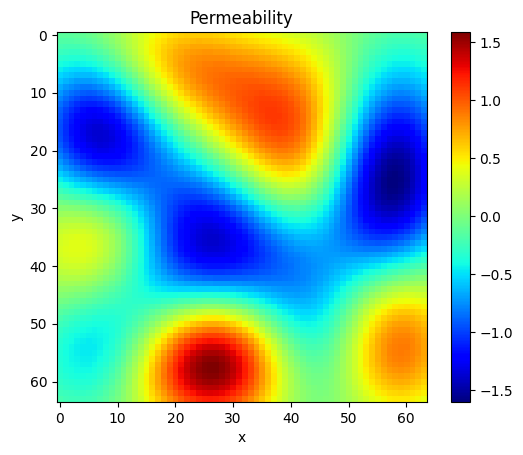

np.min(perm) = 0.2022400049215277
np.max(perm) = 4.8863744404705285


0

In [148]:
def perm_fig():
    print('inside the main function')
#     nx0 = 64
#     nx1 = 64
#     lcor = 0.1
#     xdata = compute_mesh(nx0, nx1)
#     cmat = compute_cv_matrix(xdata, lcor)
#     log_perm = 1.0 * np.reshape(generate_random_field(cmat), (nx0, nx1))
    
    plt.figure()
    plt.title('Permeability')
    plt.imshow(np.log(perm))
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.savefig('perm_field.png')
    plt.show()
    # np.save('log_perm.npy', log_perm)
    # perm = np.exp(log_perm)
    # np.save('perm.npy', perm)
    print('np.min(perm) = ' + str(np.min(perm)))
    print('np.max(perm) = ' + str(np.max(perm)))
    # eigh_val, eigh_vec = generate_random_field(cmat)
    # svec = eigh_vec[:, -1]
    # print(np.dot(cmat, svec) / svec)
    # print(eigh_val)
    return 0

perm_fig()